In [12]:
import numpy as np
import random
import pandas as pd
from deap import base, creator, tools, algorithms
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Load your data files
away_charge_results = pd.read_csv('C:/Users/sayan/Downloads/EVCS/Data/Howard_Baltimore/Phase2_FinalCode/away_charge_results_currenthighest.csv')
taz_data = pd.read_excel('C:/Users/sayan/Downloads/EVCS/Data/Howard_Baltimore/Phase2_FinalCode/TAZODNew2.xlsx')



In [13]:
# Step 1: Extract unique TAZs based on Origin_Lat and Origin_Lon, and sum trips
taz_data_unique = taz_data.groupby(['Origin_Lat', 'Origin_Lon'], as_index=False).agg({'Trips': 'sum'})

# Check how many unique TAZs we have (should be 1397)
print(f"Total Unique TAZs: {len(taz_data_unique)}")
print(taz_data_unique.head())

# Step 2: Compute proportion of trips for each TAZ
total_trips_all_taz = taz_data_unique['Trips'].sum()
taz_data_unique['Proportion'] = taz_data_unique['Trips'] / total_trips_all_taz

# Print to verify Proportion
print(taz_data_unique[['Origin_Lat', 'Origin_Lon', 'Trips', 'Proportion']].head())

# Step 3: Calculate the total number of EV trips (from the away_charge_results file)
total_ev_trips = len(away_charge_results)

# Step 4: Distribute EV trips proportionally across TAZs
taz_data_unique['EV_Trips'] = np.round(taz_data_unique['Proportion'] * total_ev_trips).astype(int)

# Print to verify EV Trips
print(taz_data_unique[['Origin_Lat', 'Origin_Lon', 'Trips', 'Proportion', 'EV_Trips']].head())


taz_data_unique.to_csv('C:/Users/sayan/Downloads/EVCS/Data/Howard_Baltimore/Phase2_FinalCode/taz_data_unique_ev_trips.csv', index=False)


Total Unique TAZs: 1397
   Origin_Lat  Origin_Lon  Trips
0   38.730583  -76.549986  10730
1   38.776273  -76.540340   5127
2   38.779845  -76.686402   6829
3   38.788036  -76.528255   5218
4   38.794903  -76.649481  14323
   Origin_Lat  Origin_Lon  Trips  Proportion
0   38.730583  -76.549986  10730    0.000543
1   38.776273  -76.540340   5127    0.000259
2   38.779845  -76.686402   6829    0.000346
3   38.788036  -76.528255   5218    0.000264
4   38.794903  -76.649481  14323    0.000725
   Origin_Lat  Origin_Lon  Trips  Proportion  EV_Trips
0   38.730583  -76.549986  10730    0.000543       142
1   38.776273  -76.540340   5127    0.000259        68
2   38.779845  -76.686402   6829    0.000346        90
3   38.788036  -76.528255   5218    0.000264        69
4   38.794903  -76.649481  14323    0.000725       189


In [27]:
from scipy.spatial import cKDTree

# Use the unique TAZ data with Origin_Lat, Origin_Lon, and EV_Trips
num_stations = 2113  # Example, change as needed
num_taz = len(taz_data_unique)  # Number of unique TAZs (1397)

# Decision variables for each station
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 0, 1)  # Binary decision for station placement
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, num_taz)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Parameters and Costs
construction_cost = 21000
operation_cost = 3000
pile_cost = 6500
land_use_cost = 5000
ce_on_peak = 0.33
pe_on_peak = 0.35

# Power Network Parameters
V_min, V_max = 0.95, 1.05
I_max = 200
base_voltage = 11  # Base voltage in kV
line_resistance = 0.1  # Line resistance (Ohms)
line_reactance = 0.2  # Line reactance (Ohms)

# Lower-Level Objective: Minimize Charging Cost
def lower_level_cost(x, y):
    # Iterate over the number of TAZs, since we place stations in TAZs
    charging_cost = sum([x[i] * taz_data_unique['EV_Trips'].iloc[i] for i in range(min(len(x), len(taz_data_unique)))]) * 100
    return charging_cost

# Upper-Level Objective: Maximize Profit with a geographic spread penalty
def upper_level_profit(individual):
    x = individual[:num_taz]  # Decision variables are based on the number of TAZs
    y = [4] * num_stations  # Fixed number of chargers per station (4)

    # Use the number of EV trips in each TAZ (taz_data_unique['EV_Trips'])
    # Ensure the number of stations and TAZs do not exceed each other
    total_ev_trips = sum([x[i] * taz_data_unique['EV_Trips'].iloc[i] for i in range(min(len(x), len(taz_data_unique)))])

    # Calculate revenue based on EV trips
    Rcharging = total_ev_trips * (pe_on_peak - ce_on_peak)

    # Costs
    Cop = sum(x) * operation_cost
    Ccon = sum(x) * construction_cost
    Cp = sum(station * pile * pile_cost for station, pile in zip(x, y))
    Cl = sum(x) * land_use_cost

    # Optimize the Geographic spread penalty using KDTree
    station_coords = np.array([[taz_data_unique['Origin_Lat'].iloc[i], taz_data_unique['Origin_Lon'].iloc[i]] for i in range(len(taz_data_unique)) if x[i] == 1])

    if len(station_coords) > 1:
        tree = cKDTree(station_coords)
        distances, _ = tree.query(station_coords, k=2)  # Find the nearest station for each station
        # distances[:, 1] is the distance to the nearest neighbor (k=2 gives self-distance and neighbor)
        nearest_distances = distances[:, 1]
        geographic_penalty = sum([1 / (dist ** 2) if dist > 0 else 10000 for dist in nearest_distances])  # Apply penalty based on nearest distances
    else:
        geographic_penalty = 0  # No penalty if there's only one station

    # Profit calculation with geographic spread penalty
    profit = Rcharging - (Cop + Ccon + Cp + Cl) - geographic_penalty
    return -profit  # NSGA-II minimizes objectives

# Power Network Constraints
def power_network_constraints(V, I, P, x, y):
    # Voltage Constraints
    voltage_constraint = all(V_min <= V_i <= V_max for V_i in V)
    
    # Power Balance Constraints (P[i][i] - sum of P[i][j] over all j = 0)
    power_balance_constraint = all((P[i, i] - sum(P[i, j] for j in range(len(V)))) == 0 for i in range(len(V)))
    
    # Current Constraints
    current_constraint = all(I_ij <= I_max for I_ij in I)
    
    return voltage_constraint and power_balance_constraint and current_constraint

# # Facility Constraints: Charging demand must not exceed charging pile capacity
# def facility_constraints(x, y):
#     facility_constraint = all(sum(zimt for zimt in range(len(away_charge_results))) <= xi * yi for xi, yi in zip(x, y))
#     return facility_constraint

# Maximum Stations per TAZ Constraint: Ensure no more than one station per TAZ
def max_stations_constraints(x):
    return all(xi <= 2 for xi in x)

# SoC Constraints: Ensuring State of Charge stays within bounds
def soc_constraints(Soc_min=0.25, Soc_max=0.90):
    soc_constraint = all(Soc_min <= soc <= Soc_max for soc in np.random.uniform(Soc_min, Soc_max, size=len(away_charge_results)))
    return soc_constraint

# Function to place stations in TAZs (ensuring proper station placement logic)
def place_stations(x, num_stations):
    placed_stations = []
    total_stations = 0

    # Case 1: If the number of stations is less than or equal to the number of TAZs
    if num_stations <= num_taz:
        for i in range(num_taz):
            if x[i] == 1 and total_stations < num_stations:
                placed_stations.append(i)
                total_stations += 1

    # Case 2: If the number of stations is greater than the number of TAZs
    else:
        # First, place one station in each TAZ
        for i in range(num_taz):
            placed_stations.append(i)
            total_stations += 1
            if total_stations >= num_stations:
                break
        
        # Then, place additional stations in TAZs with the highest demand
        while total_stations < num_stations:
            for i in range(num_taz):
                if total_stations < num_stations:
                    placed_stations.append(i)  # Add additional stations in the same TAZ
                    total_stations += 1

    return placed_stations

# Evaluate the individual solutions with the adjusted logic
def evaluate(individual):
    x = individual[:num_taz]
    y = [4] * num_stations  # Fixed number of chargers per station (4)
    
    # Upper-Level Objective: Profit Maximization
    upper_obj = upper_level_profit(individual)
    
    # Lower-Level Objective: Cost Minimization
    lower_obj = lower_level_cost(x, y)
    
    # Power Network Constraint Placeholder Values
    V = [1.0] * len(x)  # Placeholder for voltage at each node
    I = [50] * len(x)  # Placeholder for current at each line
    P = np.zeros((len(x), len(x)))  # Placeholder for power flow
    
    # Constraints
    #facility_constraint = facility_constraints(x, y)
    soc_constraint = soc_constraints()
    max_stations_constraint = max_stations_constraints(x)
    power_constraints = power_network_constraints(V, I, P, x, y)

#     # Log constraint status
#     print(f"Facility constraint: {facility_constraint}")
#     print(f"SoC constraint: {soc_constraint}")
#     print(f"Max stations constraint: {max_stations_constraint}")
#     print(f"Power constraints: {power_constraints}")
    
    # Ensure all constraints are satisfied
    if not (soc_constraint and max_stations_constraint and power_constraints):
        return float('inf'), float('inf')  # Penalty if constraints are violated

    return upper_obj, lower_obj

# Register Genetic Algorithm Operations
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selNSGA2)

# Genetic Algorithm Parameters
population_size = 100
generations = 50

# Create the initial population
population = toolbox.population(n=population_size)

# Run the NSGA-II Algorithm
algorithms.eaMuPlusLambda(population, toolbox, mu=population_size, lambda_=population_size, cxpb=0.9, mutpb=0.1, ngen=generations, 
                          stats=None, halloffame=None, verbose=True)

# Extracting Results
fronts = tools.sortNondominated(population, len(population), first_front_only=True)
pareto_front = fronts[0]

# Output Results for Charging Stations
charging_stations = []

# Function to place stations
def place_stations(x, num_stations):
    stations_placed = []
    stations_count = 0
    for i in range(len(x)):
        if stations_count >= num_stations:
            break
        if x[i] == 1:
            stations_placed.append(i)
            stations_count += 1
    # If there are more stations than TAZs, place additional stations with offsets
    while stations_count < num_stations:
        for i in range(len(x)):
            if stations_count >= num_stations:
                break
            stations_placed.append(i)  # Reuse TAZs
            stations_count += 1
    return stations_placed

# Extracting Results
fronts = tools.sortNondominated(population, len(population), first_front_only=True)
pareto_front = fronts[0]

# Output Results for Charging Stations
charging_stations = []

# Loop through the pareto_front to extract results for each individual
for ind in pareto_front:
    stations_placed = place_stations(ind[:num_taz], num_stations)

    # Create DataFrame for all charging stations, ensuring correct station-to-TAZ mapping
    charging_stations = [
        {
            'Station': i,
            'TAZ': station,
            'Latitude': taz_data_unique.loc[station, 'Origin_Lat'],
            'Longitude': taz_data_unique.loc[station, 'Origin_Lon'],
            'Piles': 4,
            'Cost': lower_level_cost(ind[:num_taz], [4] * num_stations),
            'Profit': -upper_level_profit(ind)
        }
        for i, station in enumerate(stations_placed)
    ]


df_charging_stations = pd.DataFrame(charging_stations)

# Save the results to a CSV file
df_charging_stations.to_csv('C:/Users/sayan/Downloads/EVCS/Data/Howard_Baltimore/Phase2_FinalCode/charging_stations_locations.csv', index=False)


gen	nevals
0  	100   
1  	100   
2  	100   
3  	100   
4  	100   
5  	100   
6  	100   
7  	100   
8  	100   
9  	100   
10 	100   
11 	100   
12 	100   
13 	100   
14 	100   
15 	100   
16 	100   
17 	100   
18 	100   
19 	100   
20 	100   
21 	100   
22 	100   
23 	100   
24 	100   
25 	100   
26 	100   
27 	100   
28 	100   
29 	100   
30 	100   
31 	100   
32 	100   
33 	100   
34 	100   
35 	100   
36 	100   
37 	100   
38 	100   
39 	100   
40 	100   
41 	100   
42 	100   
43 	100   
44 	100   
45 	100   
46 	100   
47 	100   
48 	100   
49 	100   
50 	100   


(28765848.620678257, 8300500.0)
(29012981.98459481, 8267700.0)
(28309495.38782534, 8541800.0)
(29734737.205740772, 8244500.0)
(31418131.32898785, 8073100.0)
(29908288.726968437, 8145600.0)
(28351087.83675725, 8400300.0)


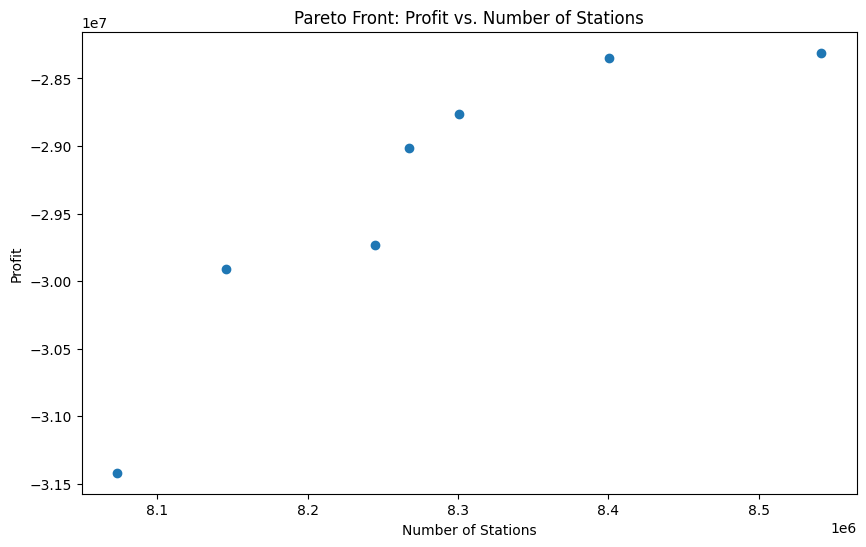

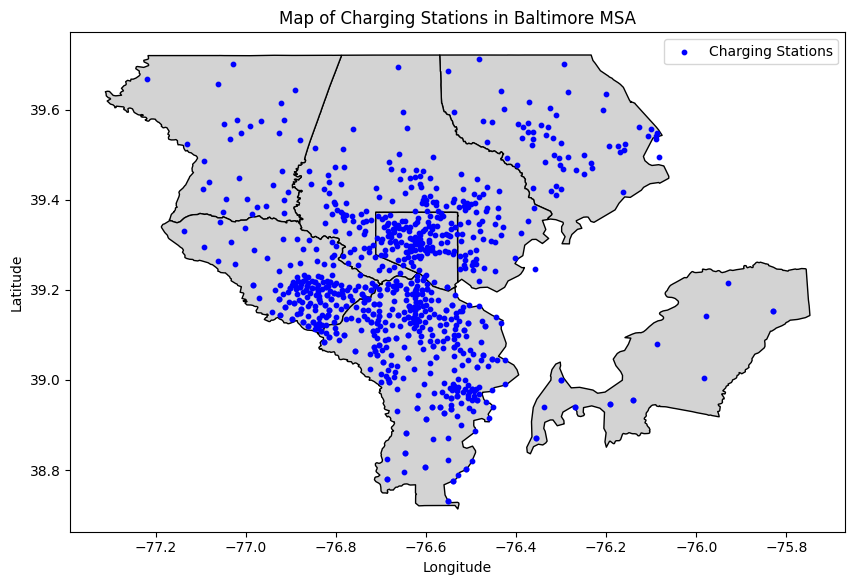

In [23]:
# Check the fitness values before plotting
for ind in pareto_front:
    print(ind.fitness.values)

# If the fitness values look fine, proceed with the plot
plt.figure(figsize=(10, 6))
profits = [-ind.fitness.values[0] for ind in pareto_front if ind.fitness.valid]
stations = [ind.fitness.values[1] for ind in pareto_front if ind.fitness.valid]
plt.scatter(stations, profits)
plt.xlabel('Number of Stations')
plt.ylabel('Profit')
plt.title('Pareto Front: Profit vs. Number of Stations')
plt.show()


# Visualization: Map of Charging Stations
# Load the Baltimore MSA shapefile
baltimore_msa = gpd.read_file('C:/Users/sayan/Downloads/EVCS/Data/Howard_Baltimore/Phase2_FinalCode/MD_Metro_Counties/MD_Metro_Counties.shp')

# Convert charging stations DataFrame to a GeoDataFrame
df_charging_stations['geometry'] = df_charging_stations.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gdf_charging_stations = gpd.GeoDataFrame(df_charging_stations, geometry='geometry')

# Plot the map with charging station locations
fig, ax = plt.subplots(figsize=(10, 8))
baltimore_msa.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf_charging_stations.plot(ax=ax, color='blue', markersize=10, marker='o', label='Charging Stations')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Map of Charging Stations in Baltimore MSA')
plt.legend()
plt.show()



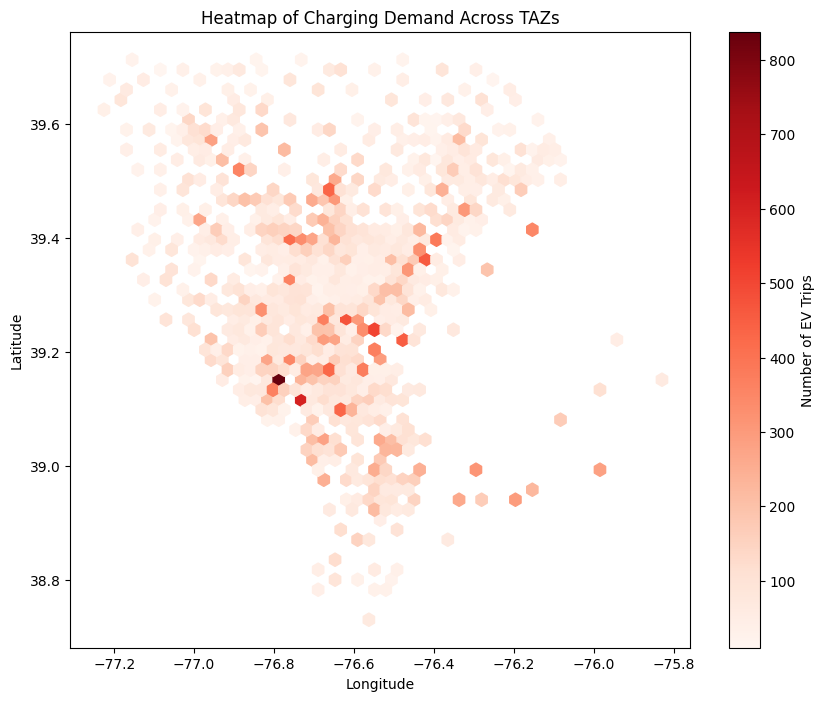

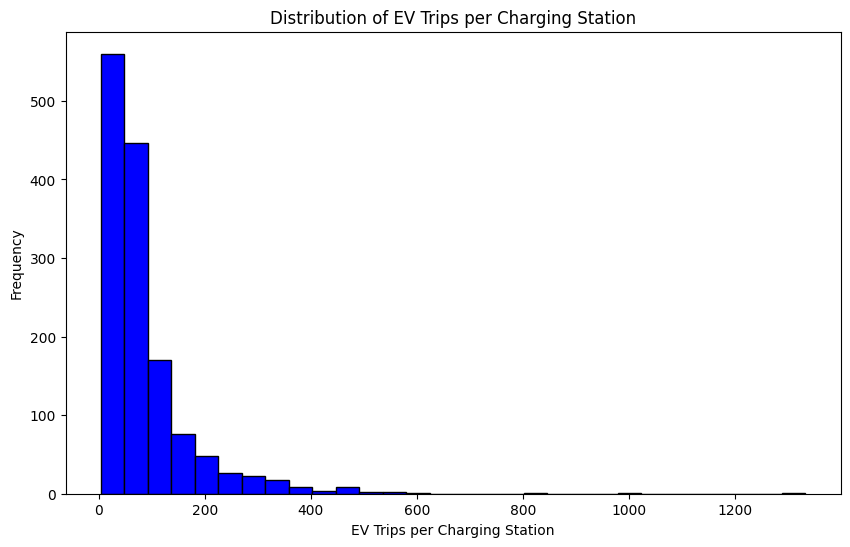

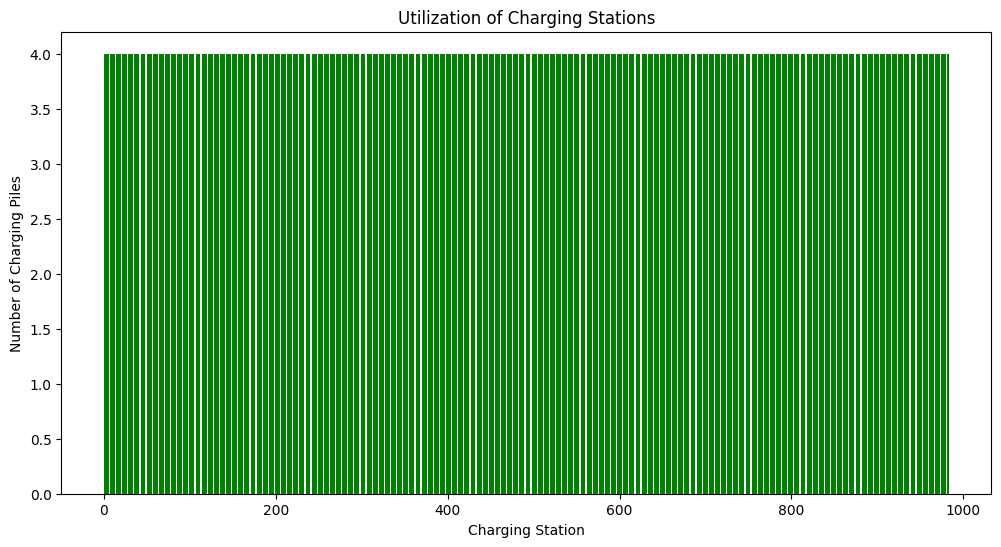

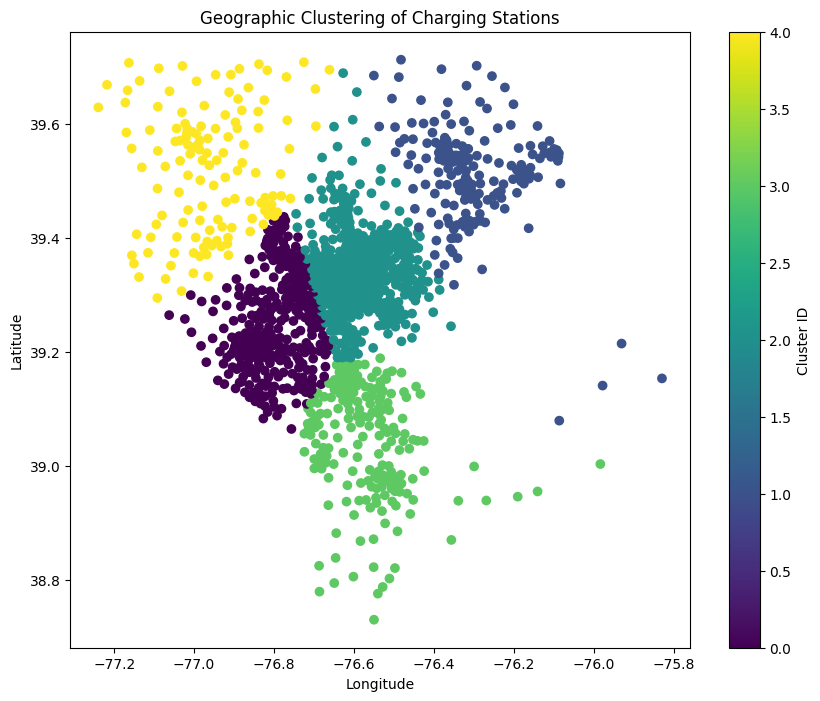

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# Assuming df_charging_stations and taz_data_unique are the dataframes created earlier

# ---------------------------------------------------
# 1. Heatmap of Charging Demand by TAZ (Density Plot)
# ---------------------------------------------------
plt.figure(figsize=(10, 8))
plt.hexbin(taz_data_unique['Origin_Lon'], taz_data_unique['Origin_Lat'], gridsize=50, C=taz_data_unique['EV_Trips'], cmap='Reds')
plt.colorbar(label='Number of EV Trips')
plt.title('Heatmap of Charging Demand Across TAZs')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# ---------------------------------------------------
# 2. Histogram of EV Trips per Charging Station
# ---------------------------------------------------
plt.figure(figsize=(10, 6))
plt.hist(taz_data_unique['EV_Trips'], bins=30, color='blue', edgecolor='black')
plt.title('Distribution of EV Trips per Charging Station')
plt.xlabel('EV Trips per Charging Station')
plt.ylabel('Frequency')
plt.show()

# ---------------------------------------------------
# 3. Charging Station Utilization Plot (Bar Chart)
# ---------------------------------------------------
plt.figure(figsize=(12, 6))
plt.bar(df_charging_stations['Station'], df_charging_stations['Piles'], color='green')
plt.title('Utilization of Charging Stations')
plt.xlabel('Charging Station')
plt.ylabel('Number of Charging Piles')
plt.show()



# ---------------------------------------------------
# 6. Geographic Cluster Analysis of Charging Stations
# ---------------------------------------------------
coords = taz_data_unique[['Origin_Lat', 'Origin_Lon']].values
kmeans = KMeans(n_clusters=5, random_state=0).fit(coords)
taz_data_unique['Cluster'] = kmeans.labels_

plt.figure(figsize=(10, 8))
plt.scatter(taz_data_unique['Origin_Lon'], taz_data_unique['Origin_Lat'], c=taz_data_unique['Cluster'], cmap='viridis')
plt.colorbar(label='Cluster ID')
plt.title('Geographic Clustering of Charging Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
